# MOABB Classifier comparison

This notebook takes multiple files and does the following pipeline:
1) Import data and pre-process
2) For each stimulus type 
    1) Run classifiers (i.e., CCA, MEC, MSI, and RG)
    2) Store accuracy values

A final plot for each stimulus type is plotted 

In [1]:
# Default libraries
import re
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from moabb.datasets import Wang2016, SSVEPExo
from moabb.paradigms import FilterBankSSVEP, SSVEP
from moabb.pipelines import ExtendedSSVEPSignal
from sklearn.linear_model import LogisticRegression
from moabb.evaluations import CrossSubjectEvaluation


# Import custom libraries
from functions import data_tools
from functions import processing
from functions import classification
from functions.FeatureExtractorSSVEP import FeatureExtractorCCA as CCA
from functions.FeatureExtractorSSVEP import FeatureExtractorMSI as MSI
from functions.FeatureExtractorSSVEP import FeatureExtractorMEC as MEC

# Magic command to reload libraries
%reload_ext autoreload


<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\Daniel\miniconda3\envs\ssvep-validation\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


## Settings

Note that if the `Wang2016` is not already downloaded, it'll be downloaded the first time you run this section of the code.

In [2]:
# Import and epoch data
dataset = Wang2016()
dataset.subject_list = dataset.subject_list[:2]

data = dataset.get_data()
eeg_channels = ["O1","Oz","O2"]

# Information from dataset description
nsubjects = len(data)
# labels_dict = {"13":0, "17":2, "21":1}  # The order is changed because the labels in the dataset are incorrect
# stimulus_freqs = [int(f) for f in labels_dict.keys()]

stimulus_freqs = [float(freq) for freq in dataset.event_id.keys()]  # Stimulus frequencies [Hz]
srate = data[1]["0"]["0"].info['sfreq'] # Sampling rate [Hz]
tmin = 0.5  # Time of start of SSVEP stimulus [sec]
tmax = 5.5  # Time of end of SSVEP stimulus [sec]

# Classifier settings
# - Create CCA subbands like in Chen et al. (2015) paper
first_column = np.arange(1, 11) * 8
second_column = np.full(10, 88)
cca_subbands = np.column_stack((first_column, second_column))
harmonic_count = 2
classifiers = ["fbCCA", "MSI", "MEC", "RG_logreg"]

# Create an empty dataframe to store the accuracies
accuracy_df = pd.DataFrame(
    index = np.arange(0, nsubjects),
    columns = classifiers
    )
accuracy_df.index.name = "Subject"

Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data


## Separate epochs

From the raw recording datasets, create the EEG epochs using just the periods where the SSVEP stimulus was active.

In [3]:
# Preallocate data
epochs_list = [None] * len(data)
events_list = [None] * len(data)

# Obtain epochs and events
for s, subject in data.items():
    [events_list[s-1], epochs_list[s-1]] = data_tools.moabb_events_to_np(
        mne_raw = subject["0"]["0"],
        tmin = tmin,
        tmax = tmax,
        events_dict = dataset.event_id,
        chans = eeg_channels
        )
    
# Convert lists to np.ndarrays
# eeg_channels = data[1]["0"]["0"].ch_names
epochs_np = np.float32(np.array(epochs_list))
events_np = np.array(events_list[0][:,2]) - 1   # The `-1` is to make the labels start at 0

## Classifiers

### Riemmanian geometry + logistic regression

In [4]:
paradigm_fb = FilterBankSSVEP(
    filters = None,
    n_classes = 10,
    tmin = tmin,
    tmax = tmax,
    channels = eeg_channels,
)

# paradigm = SSVEP(
#     fmin = 6,
#     fmax = 90,
#     n_classes = 5,
#     tmin = tmin,
#     tmax = tmax,
# )

pipeline_rg = {}
pipeline_rg["RG+LogReg"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="lwf"),
    TangentSpace(),
    LogisticRegression(solver="lbfgs", multi_class="auto"),
)

evaluation_rg = CrossSubjectEvaluation(
    paradigm = paradigm_fb,
    datasets = dataset,
    overwrite = False
)

accuracy_rg = evaluation_rg.process(pipeline_rg)


Choosing the first 10 classes from all possible events
Trial data de-meaned and concatenated with a buffer to create continuous data
c:\Users\Daniel\miniconda3\envs\ssvep-validation\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:312: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return func(X, **(kw_args if kw_args else {}))
Trial data de-meaned and concatenated with a buffer to create continuous data
c:\Users\Daniel\miniconda3\envs\ssvep-validation\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:312: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return func(X, **(kw_args if kw_args else {}))
Trial data de-meaned and concatenated with a buffer to create continuous data
c:\Users\Daniel\miniconda3\envs\ssvep-validation\Lib\site-packages\sklearn\preprocessing\_function_tr

In [5]:
accuracy_df["RG_logreg"] = accuracy_rg["score"]

In [6]:
## Testing code, might have to be removed
# Preallocate data
# rg_accuracies = np.zeros(nsubjects)

# # Classify all epochs per subject
# for s, subject in enumerate(epochs_np):
#     rg_predictions = classification.fb_rg_logreg(
#         eeg_data = subject,
#         stim_freqs = stimulus_freqs,
#         eeg_channels = eeg_channels, 
#         srate = srate,
#         labels = events_np,
#         )
    
#     rg_accuracies[s] = accuracy_score(events_np, rg_predictions)

# # Store accuracies in dataframe
# accuracy_df['RG_logreg'] = rg_accuracies

In [7]:
## Testing code, might have to be removed
# rg_accuracies = np.zeros(nsubjects)
# for [s, subject] in enumerate(epochs_np):
#     rg_predictions = classification.rg_logreg(
#         eeg_data = subject,
#         labels = events_np,
#         )
    
#     rg_accuracies[s] = accuracy_score(events_np, rg_predictions)

### fbCCA

In [8]:
# Prototype and preallocate data
cca = CCA()
cca_accuracies = np.zeros(nsubjects)

cca.setup_feature_extractor(
    harmonics_count = harmonic_count,
    targets_frequencies = stimulus_freqs,
    sampling_frequency = srate,
    samples_count = epochs_np.shape[-1],
    filter_order = 12,
    subbands = cca_subbands
    )
    

# Classify all epochs per subject
for s, subject in enumerate(epochs_np):
    cca_features = cca.extract_features(subject)
    cca_predictions = np.argmax(np.max(np.squeeze(cca_features), axis=1), axis=1)
    cca_accuracies[s] = accuracy_score(events_np, cca_predictions)


In [9]:

accuracy_df["fbCCA"] = cca_accuracies
    

### MEC

In [10]:
# Prototype and preallocate data
mec = MEC()
mec_accuracies = np.zeros(nsubjects)

mec.setup_feature_extractor(
    harmonics_count = harmonic_count,
    targets_frequencies = stimulus_freqs,
    sampling_frequency = srate,
    samples_count = epochs_np.shape[-1]
)

# Classify all epochs per subject
for s, subject in enumerate(epochs_np):
    mec_features = mec.extract_features(subject)
    mec_predictions = np.argmax(np.squeeze(mec_features), axis=1)
    mec_accuracies[s] = accuracy_score(events_np, mec_predictions)

accuracy_df["MEC"] = mec_accuracies

### MSI

In [11]:
# Prototype and preallocate data
msi = MSI()
msi_accuracies = np.zeros(nsubjects)

msi.setup_feature_extractor(
    harmonics_count = harmonic_count,
    targets_frequencies = stimulus_freqs,
    sampling_frequency = srate,
    samples_count = epochs_np.shape[-1]
)

# Classify all epochs per subject
for s, subject in enumerate(epochs_np):
    msi_features = msi.extract_features(subject)
    msi_predictions = np.argmax(np.squeeze(msi_features), axis=1)
    msi_accuracies[s] = accuracy_score(events_np, msi_predictions)

accuracy_df["MSI"] = msi_accuracies

## Visualization

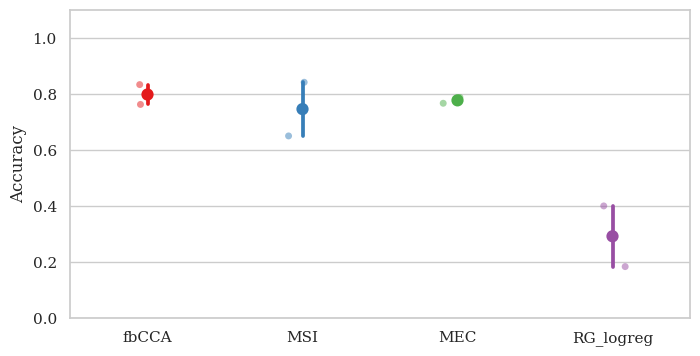

In [12]:
classifiers = ['fbCCA', 'MSI', 'MEC', 'RG_logreg']

# stimulus_accuracy = accuracy_df[accuracy_df["Stimulus"]==stimulus]

fig, ax = plt.subplots(facecolor="white", figsize=[8, 4])
sns.stripplot(
    data=accuracy_df,
    ax=ax,
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=accuracy_df, ax=ax, palette="Set1")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.1)
plt.show()

### Boxplot

In [13]:
classifiers = ["fbCCA", "MSI", "MEC", "RG_logreg"]
# accuracy_df[classifiers[0]] = accuracy_rg["score"]

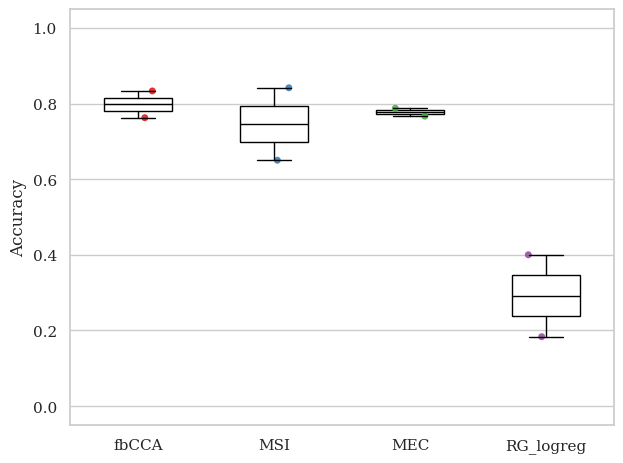

In [20]:
# Create a 2x2 subplot grid
fig, ax = plt.subplots()

sns.boxplot(
    data = accuracy_df[classifiers],
    ax = ax,
    color = "black",
    boxprops=dict(facecolor='none'),
    # fill = False,
    width = 0.5,
    linewidth = 1   
)

sns.stripplot(
    data = accuracy_df[classifiers],
    ax = ax,
    jitter = 0.15,
    alpha = 0.9,
    zorder = 1,
    palette = "Set1",
)

ax.set_ylim(-0.05, 1.05) 

ax.set_ylabel("Accuracy")
# ax.set_xlabel("Classifier")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot
fig.savefig("figures\\moabb_boxplot_comparison.svg")
